In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

# Data retrival and feature engineering

In [2]:
df = pd.read_csv("./data/grouped_irradiance/grouped_irradiance.csv", delim_whitespace=True, parse_dates=["Time"])

In [3]:
df = df.assign(eff_irradiance=(df.irr_dir * 0.9))
df = df.assign(month=df.Time.dt.month_name())
df.head()

,Time,irr_g,irr_dir,irr_diff,temp,city,eff_irradiance,month
0,2010-01-01 00:00:00,0.0,0.0,0.0,-0.18,Zurich,0.0,January
1,2010-01-01 01:00:00,0.0,0.0,0.0,-0.06,Zurich,0.0,January
2,2010-01-01 02:00:00,0.0,0.0,0.0,0.06,Zurich,0.0,January
3,2010-01-01 03:00:00,0.0,0.0,0.0,0.18,Zurich,0.0,January
4,2010-01-01 04:00:00,0.0,0.0,0.0,0.07,Zurich,0.0,January


In [57]:
W0 = 80.  # power at pos 0
W1 = 0.   # power at pos 1
T0 = -10. # Temp at pos 0
T1 = 20.  # Temp at pos 1
a = (W1 - W0)/(T1-T0)  # Linear relation coefficient
b = W0 - a*T0  # Linear relation coefficien

temp_serie = (df.temp* a + b - df.eff_irradiance)
temp_serie = temp_serie.apply(lambda x: x if x>0 else 0)
df = df.assign(heat_consumption=temp_serie)
df = df.assign(heat_consumption_month= temp_serie*30 )

Text(0.5, 0, '')

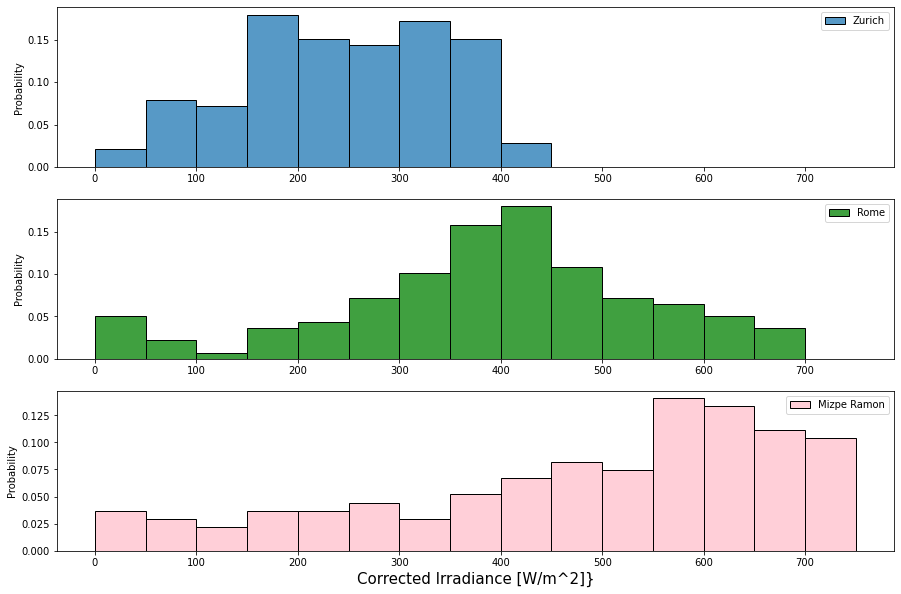

In [58]:
bins_irr = np.arange(0,800,50)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Zurich")], x="eff_irradiance", stat="probability", ax=ax[0], bins=bins_irr)
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Rome")], x="eff_irradiance", stat="probability", ax=ax[1], bins=bins_irr, color="green")
sns.histplot(data=df[(df.eff_irradiance > 0)&(df.city =="Mizpe")], x="eff_irradiance", stat="probability", ax=ax[2], bins=bins_irr, color="pink")
ax[2].set_xlabel("Corrected Irradiance [W/m^2]}", fontsize=15)
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[0].set_xlabel("")
ax[1].set_xlabel("")

Text(0.5, 0, '')

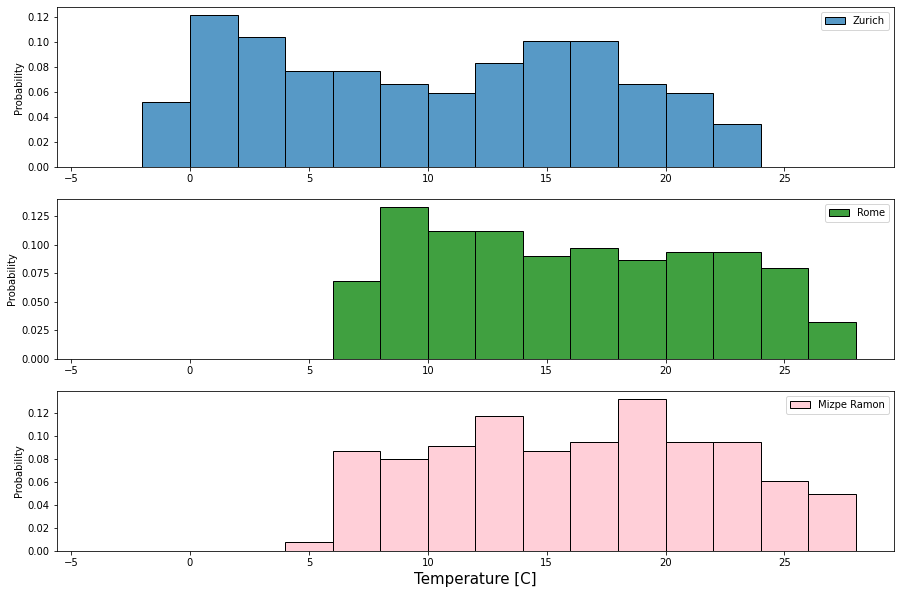

In [59]:
bins_temp = np.arange(-4,30,2)
fig, ax = plt.subplots(3,1,figsize=(15,10))
sns.histplot(data=df[(df.city =="Zurich")], x="temp", stat="probability", ax=ax[0], bins=bins_temp)
sns.histplot(data=df[(df.city =="Rome")], x="temp", stat="probability", ax=ax[1], bins=bins_temp, color="green")
sns.histplot(data=df[(df.city =="Mizpe")], x="temp", stat="probability", ax=ax[2], bins=bins_temp, color="pink")
ax[0].legend(["Zurich"])
ax[1].legend(["Rome"])
ax[2].legend(["Mizpe Ramon"])
ax[2].set_xlabel("Temperature [C]", fontsize=15)
ax[0].set_xlabel("")
ax[1].set_xlabel("")

# Seasonal Plots

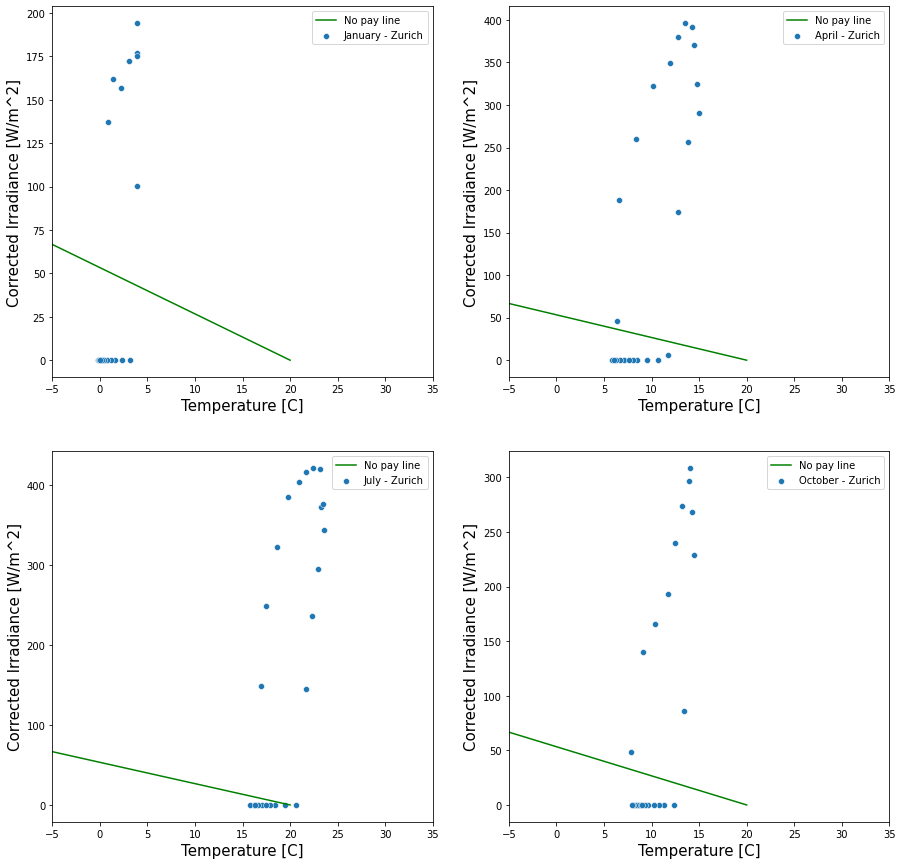

In [60]:
city = "Zurich"

fig, ax = plt.subplots(2,2,figsize=(15,15))
sns.scatterplot(data=df[(df.Time.dt.month == 1)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[0,0])
sns.scatterplot(data=df[(df.Time.dt.month == 4)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[0,1])
sns.scatterplot(data=df[(df.Time.dt.month == 7)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[1,0])
sns.scatterplot(data=df[(df.Time.dt.month == 10)&(df.city == city)], y="eff_irradiance", x="temp", ax=ax[1,1])


ax = np.reshape(ax,4)

for a in ax:
    a.plot([-10,20],[80,0], color="green")
    a.set_xlim(-5,35)
    a.set_ylabel("Corrected Irradiance [W/m^2]", fontsize=15)
    a.set_xlabel("Temperature [C]",fontsize=15)

ax[0].legend(["No pay line",f"January - {city}"])
ax[1].legend(["No pay line",f"April - {city}"])
ax[3].legend(["No pay line",f"October - {city}"])
ax[2].legend(["No pay line",f"July - {city}"])


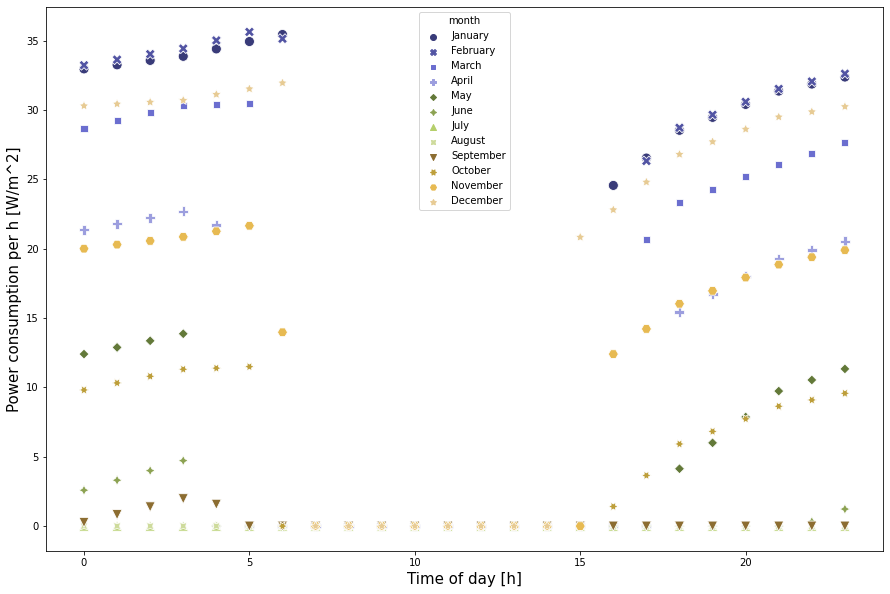

In [61]:
city = "Rome"
df_slice = df.loc[df.city == city]

fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=df_slice.Time.dt.hour, 
                y=df_slice.heat_consumption, 
                hue=df_slice.month, 
                ax=ax, 
                palette="tab20b",
                legend="full",
                style=df_slice.month,
                s=100)

ax.set_xlabel("Time of day [h]", fontsize=15)
ax.set_ylabel("Power consumption per h [W/m^2]",fontsize=15)
plt.show()


In [62]:
print("Price per m^2 per year ",(df_slice.heat_consumption * 30).sum() /1000 * 0.1)

Price per m^2 per year  7.418754000000002


# Biomass production

Now this can get a bit complicated, here we do the following assumptions:
- Assume nutrients (whater, CO2, nutrients) to be ok, for both on land and in isolation
- Then plant growth depends mainly on light and temperature (assume trigger temperature 17C)
- Assume plant collection efficiency in land to be about 66% (light reflection on leaf, this is not true for algae) and 100% in isolation (because of reflective surfaces)
- Neglect saturation (this might actually be an issue)

Making the exact calculation of the biomass is delicated, here we just compute the ratio with land based farming, so that we don't need to compute a  few of the complicated and plant dependent quantities. The ratio should be fairly predictive.

In [69]:
land_collection_eff = 0.66 # from calculation based on fixed panel VS traking panel 
                           # from https://re.jrc.ec.europa.eu/pvg_tools/en/#HR

energy_price_per_kWh = 0.15         # CHF
temperature_growth_treshold = 17   # C

land_grow_start_month = 4          # April included
land_grow_stop_month = 9           # September included

iso_grow_start_month = 4           # April included
iso_grow_stop_month = 11           # November included

In [78]:
plant_revenue_per_m2 = 3000 / 10000  # soy 3000 USD per hectar

In [70]:
# cumulative land_kWh within growth_monts and for temp > treshold

land_selected = df[ (df.Time.dt.month >= land_grow_start_month) &
                    (df.Time.dt.month <= land_grow_stop_month)  &
                    (df.temp > temperature_growth_treshold)
                  ]

land_selected = land_selected.assign(eff_irradiance= df.irr_dir*land_collection_eff)

iso_no_winter = df[ (df.Time.dt.month >= iso_grow_start_month) &
                    (df.Time.dt.month <= iso_grow_stop_month) 
                  ]


In [75]:
land_tot_irr = land_selected.groupby(by="city").eff_irradiance.sum()

iso_tot_irr  = df.groupby(by="city").eff_irradiance.sum()
iso_tot_cost = df.groupby(by="city").heat_consumption_month.sum() * energy_price_per_kWh / 1000

iso_no_winter_tot_irr = iso_no_winter.groupby(by="city").eff_irradiance.sum()
iso_no_winter_tot_cost = iso_no_winter.groupby(by="city").heat_consumption_month.sum() * energy_price_per_kWh / 1000

In [96]:

final_df = pd.DataFrame({ "R" : iso_tot_irr / land_tot_irr,
                          "R No W." : iso_no_winter_tot_irr / land_tot_irr,
                          "Operation Cost [CHF/m^2]" : iso_tot_cost,
                          "Rev. iso [CHF/m^2]" : plant_revenue_per_m2 * iso_tot_irr / land_tot_irr, 
                          "Operation Cost No W. [CHF/m^2]" : iso_no_winter_tot_cost,
                          "Rev. iso No W. [CHF/m^2]"  : plant_revenue_per_m2 * iso_no_winter_tot_irr / land_tot_irr,
                          "Rev. land [CHF/m^2]" : plant_revenue_per_m2
                        })
print('''
    R :                   Ratio between land (temp triggered) irradiation and pod-isolated irradiation
    R no W.:              same but witout considering winter season for pod-isolated
    Operation cost :      cost to keep warm pod
    Operation cost No W.: same but witout considering winter season for pod-isolated
    Rev. iso :            Revenue (scaled land revenue by R)
    Rev. land :           typical revenue per m^2 in a farm
''')
final_df.head()


    R :                   Ratio between land (temp triggered) irradiation and pod-isolated irradiation
    R no W.:              same but witout considering winter season for pod-isolated
    Operation cost :      cost to keep warm pod
    Operation cost No W.: same but witout considering winter season for pod-isolated
    Rev. iso :            Revenue (scaled land revenue by R)
    Rev. land :           typical revenue per m^2 in a farm



,R,R No W.,Operation Cost [CHF/m^2],Rev. iso [CHF/m^2],Operation Cost No W. [CHF/m^2],Rev. iso No W. [CHF/m^2],Rev. land [CHF/m^2]
city,,,,,,,
Mizpe,2.364918,1.740143,10.089240,0.709475,2.969880,0.522043,0.3
Rome,2.279737,1.754169,11.128131,0.683921,3.312831,0.526251,0.3
Zurich,2.968345,2.351494,22.429206,0.890504,9.088686,0.705448,0.3
